In [1]:
import pandas as pd
import numpy as np
import fastai
from fastai.text.models.transformer import MultiHeadAttention
from fastai.vision import *
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import glob
import json
from skimage import io, transform

# Requirements

Data format:
* Faces and STFTs must have been extracted with the notebook Extract faces and sound.ipynb.
* In each video folder ('train_sample_videos', 'dfdc_train_videos_X', ...'), there must be a folder named 'face_frames' containing folders of faces and stfts for each video.

Libraries:
* pytorch
* fastai

In [2]:
PATH_ROOT_DIR = "/media/dlo/New Volume/DeepFake/"
AUDIO_EXTENSION = ".jpg"
LABEL_FILE = "metadata.json"
root_dirs = ["dfdc_train_part_3/"]

# train on all set
#root_dirs = glob(f"{PATH_ROOT_DIR}/*/")

In [16]:
###################################################################
# Data preparation (indexing of extracted faces & stft per video) #
# Custom pytorch dataset creation                                 #
###################################################################

# Data preparation
class DeepFakeDF():
    """ Indexes the faces & STFTs into a dataframe, to be used
    by the pytorch dataset. processing is a bit long"""
    def __init__(self, data_dirs, test = False):
        self.data_dirs = [f"{PATH_ROOT_DIR}{d}" for d in data_dirs]
        self.frame_dirs = [f"{d}face_frames/" for d in self.data_dirs]
        print(self.frame_dirs)
        audio = []
        video = []
        for frame_dir in self.frame_dirs:
            audio.extend(glob.glob(f"{frame_dir}*/audio*"))
            video.extend(glob.glob(f"{frame_dir}*/webcam*"))
            
        if not test:
            self.labels = self._get_labels()
        else:
            self.labels = {}
            
        self.video = video
        self.df = self._prep_df_audio(audio)
        self.video_dicts = self._prep_video_dicts(video)
        self._merge_audio_video()
        
    def get_df(self):
        return self.df
        
    def _get_labels(self):
        labels = {}
        for d in self.data_dirs:
            with open(f"{d}{LABEL_FILE}", "r") as f:
                labels.update({f"{k.split('.mp4')[0]}": v['label'] 
                             for k, v in json.load(f).items()})
                
        return labels
    
    def _merge_audio_video(self):
        """
        Audio has 1 sample per frame in any case. But the face extractor may have 
        missed some faces. This function attempts to provide a face for each audio sample.
        """
        self.df['dir'] = self.df['audio'].str.split("/").str[-4]
        
        # Actor 0:
        # Flagging frames for which actor 0 was detected
        self.df['actor_0'] = [self.video_dicts[0].get(tuple(o),np.nan) 
                              for o in self.df[['video_name', 'sample']].values.tolist()]
        
        # Creating path variables for frames in which actor 0 was detected
        act0 = self.df.loc[~self.df['actor_0'].isna()].copy()
        act0['actor_0'] = (PATH_ROOT_DIR + act0['dir'] + "/face_frames/" + act0['video_name'] 
                           + "/" + "webcam_" + act0['sample'].astype(str) + "_0" 
                           + ".jpg")
        self.df.loc[~self.df['actor_0'].isna(), 'actor_0'] = act0
        
        # Actor 1:
        # Flagging frames for which actor 1 was detected
        self.df['actor_1'] = [self.video_dicts[1].get(tuple(o),np.nan) 
                              for o in self.df[['video_name', 'sample']].values.tolist()]
        # Creating path variables for frames in which actor 1 was detected
        act1 = self.df.loc[~self.df['actor_1'].isna()].copy()
        act1['actor_1'] = (PATH_ROOT_DIR + act1['dir'] + "/face_frames/" + act1['video_name'] 
                           + "/" + "webcam_" + act1['sample'].astype(str) + "_1" 
                           + ".jpg")
        self.df.loc[~self.df['actor_1'].isna(), 'actor_1'] = act1
        
        # Filling NaNs. Forward fill per video name, so that missing faces are replaced
        # by the previous detected face.
        for vid in self.df['video_name'].unique():
            cond = (self.df['video_name'] == vid)
            
            self.df.loc[cond,'actor_0'] = (self.df.loc[cond,'actor_0']
                                           .fillna(method = 'ffill')
                                           .fillna(method = 'bfill'))
            
            self.df.loc[cond,'actor_1'] = (self.df.loc[cond,'actor_1']
                                           .fillna(method = 'ffill')
                                           .fillna(method = 'bfill'))
        
        # As not all videos have two actors, for now, simply copying the 1st actor into the 2nd
        # actor field when there is only 1 actor.
        self.df.loc[self.df['actor_1'].isna(), 'actor_1'] = self.df['actor_0']
        
        for col in ['audio', 'actor_0', 'actor_1']:
            self.df[col] = self.df[col].str.replace(PATH_ROOT_DIR,"")
        
    
    def _prep_df_audio(self, audio):
        """Returns a dataframe indexed on frames of videos.
        Contains the path to each .jpg of STFTs of video frames"""
        df = pd.DataFrame(audio, columns = ['audio'])
        df['video_name'] = df['audio'].str.split("/").str[-2]
        df['sample'] = df['audio'].str.split("/").str[-1].str.split(".").str[0].str.split("_").str[-1].astype(int)
        df['label'] = df['video_name'].apply(lambda x: self.labels.get(x,""))
        df.sort_values(by=['video_name','sample'], inplace = True)
        df['actor_0'] = ""
        df['actor_1'] = ""
        return df
    
    def _prep_video_dicts(self, video):
        """Returns dicts, one that tell if a face was detected in frames of videos,
        and one that tells if a second face was detected in frames of videos."""
        video_name, frame_name = zip(*[o.split("/")[-2:] for o in video])
        samples, actors = zip(*[o.replace(".jpg","").split("_")[-2:] for o in frame_name])
        samples = [int(o) for o in samples]
        actors = [int(o) for o in actors] 
        #samples = [int(o) for o in actors]
        #actors = [0 for o in samples]
        actor_0_present = {(v, s) : a for v, s, a in zip(video_name, samples, actors) if a == 0}
        actor_1_present = {(v, s) : a for v, s, a in zip(video_name, samples, actors) if a == 1}
        return actor_0_present, actor_1_present

    
# Custom pytorch dataset
class DeepFakeJPGDataset(Dataset):
    """DeepFakeJPGDataset. Opens .jpgs of either faces or STFTs for each frame of video.
    Returns tensors of a concatenatetion of the video's frames."""

    def __init__(self, df, col_name, transform = None, downsample_factor = 1):
        """df[col_name] has to contain paths to .jpg files,
        either of faces or of STFTs.
        transform: resize images - all cropped faces don't have the same
        shape, they won't fit together in a batch. Need to resize them,
        use transforms.Resize((150,100)) for example. 
        downsample_factor: use > 1 to not use all the frames of a video
        """
        self.x = df[col_name]
        self.y = df['label'].astype('category').cat.codes.astype(int)
        self.transform = transform
        self.downsample_factor = int(downsample_factor)
        self.col_name = col_name

    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        list_image_paths = self.x.iloc[idx]
        # Opening one every 'downsample_factor' image
        images = [PIL.Image.open(PATH_ROOT_DIR + im) 
                  for im in list_image_paths[::self.downsample_factor]]
        target = self.y.iloc[idx]
        
        # Resizing
        if self.transform:
            images = [self.transform(im) for im in images]
            
        # Normalizing the .jpgs to [-0.5, 0.5] both for 
        # faces and sound STFTs.
        # TODO: Normalize faces with imagenet stats, as the 
        # model taking faces as input is pretrained on imagenet
        images = [(np.array(im) / 255.0) - 0.5 for im in images]
        
        # Adding channel dimension to STFT images (grayscale)
        if len(images[0].shape) == 2: 
            images = [im[...,None] for im in images]
            
        # (n_frames, channels, height, width)    
        return torch.Tensor(images).permute(0,3,1,2)
    
class DeepFakeDetectionDataset(Dataset):
    """DeepFakeDetectionDataset. Merges faces & STFT datasets."""
    def __init__(self, x1, x2, y):
        self.x1,self.x2,self.y = x1,x2,y
    def __len__(self): 
        return len(self.y)
    def __getitem__(self, i): 
        return (self.x1[i], self.x2[i]), self.y[i]

#### Data indexing

In [17]:
df = DeepFakeDF(root_dirs).get_df()

['/media/dlo/New Volume/DeepFake/dfdc_train_part_3/face_frames/']


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0         gmutjqhliq
1         gmutjqhliq
2         gmutjqhliq
3         gmutjqhliq
4         gmutjqhliq
5         gmutjqhliq
6         gmutjqhliq
7         gmutjqhliq
8         gmutjqhliq
9         gmutjqhliq
10        gmutjqhliq
11        gmutjqhliq
12        gmutjqhliq
13        gmutjqhliq
14        gmutjqhliq
15        gmutjqhliq
16        gmutjqhliq
17        gmutjqhliq
18        gmutjqhliq
19        gmutjqhliq
20        gmutjqhliq
21        gmutjqhliq
22        gmutjqhliq
23        gmutjqhliq
24        gmutjqhliq
25        gmutjqhliq
26        gmutjqhliq
27        gmutjqhliq
28        gmutjqhliq
29        gmutjqhliq
             ...    
436470    zzrppdukls
436471    zzrppdukls
436472    zzrppdukls
436473    zzrppdukls
436474    zzrppdukls
436475    zzrppdukls
436476    zzrppdukls
436477    zzrppdukls
436478    zzrppdukls
436479    zzrppdukls
436480    zzrppdukls
436481    zzrppdukls
436482    zzrppdukls
436483    zzrppdukls
436484    zzrppdukls
436485    zzrppdukls
436486    zzr

In [19]:
df = df.get_df()

In [20]:
# Dataset format - indexed on frames, simple use case where predictions 
# are made independently on each frame
df.head()

,audio,video_name,sample,label,actor_0,actor_1,dir
600,dfdc_train_part_3/face_frames/aafezqchru/audio...,aafezqchru,0,FAKE,dfdc_train_part_3/face_frames/aafezqchru/webca...,dfdc_train_part_3/face_frames/aafezqchru/webca...,dfdc_train_part_3
601,dfdc_train_part_3/face_frames/aafezqchru/audio...,aafezqchru,1,FAKE,dfdc_train_part_3/face_frames/aafezqchru/webca...,dfdc_train_part_3/face_frames/aafezqchru/webca...,dfdc_train_part_3
799,dfdc_train_part_3/face_frames/aafezqchru/audio...,aafezqchru,2,FAKE,dfdc_train_part_3/face_frames/aafezqchru/webca...,dfdc_train_part_3/face_frames/aafezqchru/webca...,dfdc_train_part_3
887,dfdc_train_part_3/face_frames/aafezqchru/audio...,aafezqchru,3,FAKE,dfdc_train_part_3/face_frames/aafezqchru/webca...,dfdc_train_part_3/face_frames/aafezqchru/webca...,dfdc_train_part_3
898,dfdc_train_part_3/face_frames/aafezqchru/audio...,aafezqchru,4,FAKE,dfdc_train_part_3/face_frames/aafezqchru/webca...,dfdc_train_part_3/face_frames/aafezqchru/webca...,dfdc_train_part_3


In [21]:
# Dataset format - indexed on videos, use case where all the frames of a 
# video are used to make a TRUE/FAKE prediction.
# Each video is assigned a list of all its extracted faces and all stfts.
gb = df.groupby('video_name')
audio = gb['audio'].apply(list)
video = gb['actor_0'].apply(list)
label = gb['label'].nth(0)
df = pd.concat([audio,video,label],axis=1)
df.reset_index(inplace = True)
df.head()

"""test_df = DeepFakeDF(["test_videos/"], test = True).get_df()

gb = test_df.groupby('video_name')
audio = gb['audio'].apply(list)
video = gb['actor_0'].apply(list)
label = gb['label'].nth(0)
test_df = pd.concat([audio,video,label],axis=1)
test_df.reset_index(inplace = True)"""

['/media/dlo/New Volume/DeepFake/test_videos/face_frames/']


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0         aassnaulhq
1         aassnaulhq
2         aassnaulhq
3         aassnaulhq
4         aassnaulhq
5         aassnaulhq
6         aassnaulhq
7         aassnaulhq
8         aassnaulhq
9         aassnaulhq
10        aassnaulhq
11        aassnaulhq
12        aassnaulhq
13        aassnaulhq
14        aassnaulhq
15        aassnaulhq
16        aassnaulhq
17        aassnaulhq
18        aassnaulhq
19        aassnaulhq
20        aassnaulhq
21        aassnaulhq
22        aassnaulhq
23        aassnaulhq
24        aassnaulhq
25        aassnaulhq
26        aassnaulhq
27        aassnaulhq
28        aassnaulhq
29        aassnaulhq
             ...    
119970    zzmgnglanj
119971    zzmgnglanj
119972    zzmgnglanj
119973    zzmgnglanj
119974    zzmgnglanj
119975    zzmgnglanj
119976    zzmgnglanj
119977    zzmgnglanj
119978    zzmgnglanj
119979    zzmgnglanj
119980    zzmgnglanj
119981    zzmgnglanj
119982    zzmgnglanj
119983    zzmgnglanj
119984    zzmgnglanj
119985    zzmgnglanj
119986    zzm

In [22]:
# train/val split indices
val_perc = 0.2
n_val = int(val_perc*len(df))
shuffled_idx = np.random.permutation(df.index.tolist())

val_idx = shuffled_idx[:n_val]
train_idx = shuffled_idx[n_val:]

#### torch dataset creation

In [23]:
downsample_factor = 10 # using one every 10 frames only
n_frames = 300 // downsample_factor

# train/val torch datasets & dataloaders
tr_images = DeepFakeJPGDataset(df.iloc[train_idx].reset_index(drop = True), 
                               'actor_0', transforms.Resize((150,100)), downsample_factor)
tr_sound = DeepFakeJPGDataset(df.iloc[train_idx].reset_index(drop = True),
                               'audio', transforms.Resize((65,25)), downsample_factor)
train_ds = DeepFakeDetectionDataset(tr_images, tr_sound, tr_images.y)
train_dl = DataLoader(train_ds)

val_images = DeepFakeJPGDataset(df.iloc[val_idx].reset_index(drop = True), 
                                'actor_0', transforms.Resize((150,100)), downsample_factor)
val_sound = DeepFakeJPGDataset(df.iloc[val_idx].reset_index(drop = True), 
                               'audio', transforms.Resize((65,25)), downsample_factor)
valid_ds = DeepFakeDetectionDataset(val_images, val_sound, val_images.y)
valid_dl = DataLoader(valid_ds)

"""te_images = DeepFakeJPGDataset(test_df.reset_index(drop = True), 
                               'actor_0', transforms.Resize((150,100)), downsample_factor)
te_sound = DeepFakeJPGDataset(test_df.reset_index(drop = True),
                               'audio', transforms.Resize((65,25)), downsample_factor)
test_ds = DeepFakeDetectionDataset(te_images, te_sound, te_images.y)
test_dl = DataLoader(test_ds)"""

# fastai databunch
db = DataBunch(train_dl,valid_dl)#,test_dl=test_dl)
db.batch_size = 8

#### Models code

In [24]:
##########
# Models #
##########

# Frame embeddings
def fully_connected(layers, dropout, bn = True):
    """Returns a series of [BatchNorm1d, Dropout, Linear]*len(layers)
    The size of the linear layers is given by 'layers'. """
    model_layers = [] 
    activations = [nn.ReLU(inplace=True)] * (len(layers)-1)
    for n_in, n_out, p, actn in zip(layers[:-1], layers[1:], dropout, activations):
        model_layers += bn_drop_lin(n_in, n_out, p = p, actn = actn, bn = bn)
    return nn.Sequential(*model_layers)

class VideoAnalyzer(nn.Module):
    def __init__(self, frame_embedding_size, n_frames): 
        super().__init__()
        self.self_attention = MultiHeadAttention(5,frame_embedding_size)
        layers = [n_frames*frame_embedding_size, n_frames*frame_embedding_size // 2, 50]
        self.linears = fully_connected(layers, [0.1]*len(layers))
        self.classifier = nn.Linear(layers[-1],2)
    
    def forward(self, x):
        x = self.self_attention(x)
        x = x.contiguous().view(x.size(0), -1)
        x = self.linears(x)
        x = self.classifier(x)
        return x

    
# Global model
class DeepFakeDetector(nn.Module):
    """DeepFakeDetectionModel. This model has four main parts:
    -Face analyzer: convnet 2d pretrained on imagenet.
    -STFT analyzer: convnet 2d.
    -Face & STFT merger: fully connected network, takes the output of the two above networks
        as input, and outputs a vector (small dimension) representation of the frame's video and
        audio - frame embeddings.
    -Video analyzer: once the three above network have processed all the frames of a video, 
        the concatenation of the frame embeddings is passed to a 4th network. This network sees
        the entire video through its frame embeddings, and predicts the label TRUE/FAKE.
    """
    def __init__(self, model_face, model_stft, model_merge, model_video, n_frames): 
        super().__init__()
        self.n_frames = n_frames
        
        # two conv heads
        self.model_face = model_face
        self.model_stft = model_stft
        self.poolflat = fastai.layers.PoolFlatten()
        
        # frame embeddings
        self.model_merge = model_merge
        
        # frame embeddings aggregator, and classifier
        self.model_video = model_video

    def forward(self, *x):
        x_faces = x[0]
        x_stfts = x[1]
        
        frame_embeddings = []
        for frame in range(self.n_frames):
            
            x_face = self.model_face(x_faces[:,frame,:,:,:])
            x_face = self.poolflat(x_face)
            x_stft = self.model_stft(x_stfts[:,frame,:,:,:])
            x = torch.cat([x_face, x_stft], dim=1)
            x = self.model_merge(x)
            frame_embeddings.append(x[:,None,:])
        
        x = torch.cat(frame_embeddings, dim = 1)
        x = self.model_video(x)
        return F.log_softmax(x, dim = -1)


#### Training

In [25]:
# Submodels
model_faces = create_body(fastai.vision.models.resnet18)

model_stfts = simple_cnn(actns = [1,8,16,32,64], strides = [(2,1),(2,2),(2,2),(2,2)],
                         bn = True)

frame_embedding_size = 32
merge_layers = [512 + 64, frame_embedding_size]
model_frame = fully_connected(merge_layers, dropout = [0.1]*len(merge_layers))

model_video = VideoAnalyzer(frame_embedding_size, n_frames)
# Global model
model = DeepFakeDetector(model_faces, model_stfts, model_frame, 
                             model_video, n_frames = n_frames)


In [26]:
learn = Learner(db, model, metrics = [accuracy]).load('20_ep_51e-4')

/home/dlo/anaconda3/envs/fastai_gpu/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type DeepFakeDetector. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dlo/anaconda3/envs/fastai_gpu/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type VideoAnalyzer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [16]:
(x1,x2), y = next(iter(db.test_dl))
x1 = x1.to('cuda')
x2 = x2.to('cuda')

In [17]:
y

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [36]:
model_faces(x1[:,0,:,:]).shape

torch.Size([8, 512, 5, 4])

In [37]:
model_stfts(x2[:,0,:,:]).shape

torch.Size([8, 64])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


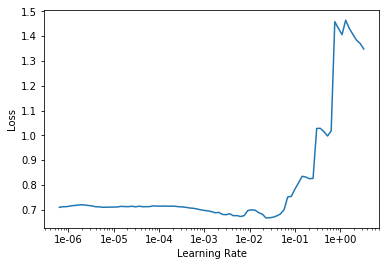

In [21]:
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(20,5*1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.811163,0.781662,0.225000,04:17
1,0.742356,0.698815,0.425000,04:16
2,0.628156,0.556962,0.712500,04:15
3,0.507033,0.525933,0.775000,04:17
4,0.428797,0.676499,0.650000,04:17
5,0.424062,0.420685,0.787500,04:15
6,0.424210,0.418869,0.812500,04:16
7,0.388338,0.347876,0.862500,04:17
8,0.359970,0.299131,0.912500,04:15
9,0.310886,0.464591,0.800000,04:16


In [27]:
learn.fit_one_cycle(4,1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.387173,0.484208,0.718213,15:30


In [12]:
learn.fit_one_cycle(10,5*1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.603848,0.540501,0.725000,01:23
1,0.405393,0.440084,0.812500,01:22
2,0.325628,0.435164,0.800000,01:22
3,0.304964,0.367607,0.862500,01:21
4,0.264422,0.386004,0.837500,01:22
5,0.207702,0.324583,0.862500,01:22
6,0.132341,0.315138,0.875000,01:22
7,0.074944,0.323226,0.875000,01:22
8,0.041357,0.328530,0.875000,01:22
9,0.025301,0.329194,0.875000,01:21


In [14]:
# For inference on the test set
learn.save('20_ep_51e-4')